# School network model
This model uses matrix expressions of school network to provide a samplewise likelihood function for primary school influenza data in Matsumoto city, Japan.

## Load and prepare data

In [6]:
using CSV
using DataFrames
datao=CSV.read("../../data/flumatsumoto_onsetdata.csv",DataFrame,copycols=true);
datar=CSV.read("../../data/flumatsumoto_retrospectivedata.csv",DataFrame,);
datao.Sex[datao.Sex.===2].=0 # Sex -> 0:Female, 1:Male
datac=datar[datar.Ill.==0,:];
dataro=datar[datar.Ill.!=0,:];
datanclasses=CSV.read("../../data/NumberOfClasses.csv",DataFrame,)[:,1:7];
datanstudents=CSV.read("../../data/NumberOfClasses.csv",DataFrame,)[:,[1,8:13...]];

In [7]:
# School incidence data
using Dates
const diZero=Dates.value(Date("2014-09-30")) # day integer for t=0
const diEnd=Dates.value(Date("2015-05-01")) # day integer for t=end
const diLen=diEnd-diZero
function d2di(d::Date) Dates.value(d)-diZero end
function di2d(di::Int) Date(Dates.UTInstant(Day(di+diZero))) end

const diOnsets=d2di.(datao.dOnset) # onset day integer for cases
const nStrata=(1,2,5,6,29)# number of strata (sex,class,grade,school) in each layer
stCase=permutedims(hcat(datao.School,datao.Grade,datao.Class,datao.Sex),[2,1])
stRetro=permutedims(hcat(datar.School,datar.Grade,datar.Class,datar.Sex),[2,1])
stCtrl=permutedims(hcat(datac.School,datac.Grade,datac.Class,datac.Sex),[2,1])
winterbreak=d2di(Date("2014-12-27")):d2di(Date("2015-1-7")) # 27 Dec - 7 Jan was winter break in school in Matsumoto
duringbreak=(x->x.+1).(winterbreak);

In [8]:
# Household data
# each household represented in a vector (student, sibling, father, mother, other)
hhCase_n=permutedims(convert(Matrix,datao[:,[:nFather,:nMother,:nEBrother,:nYBrother,:nESister,:nYSister,:nGFather,:nGMother,:nUncle,:nAunt,:nOther,:nSibling]]),[2,1])
hhCase_n=vcat(1,vcat(hhCase_n[[end;1:2],:],sum(hhCase_n[7:11,:],dims=1)))
hhCase_i=permutedims(convert(Matrix,datao[:,[:iFather,:iMother,:iEBrother,:iYBrother,:iESister,:iYSister,:iGFather,:iGMother,:iOther]]),[2,1])
hhCase_i=vcat(1,vcat(sum(hhCase_i[3:6,:],dims=1),hhCase_i[1:2,:],sum(hhCase_i[7:9,:],dims=1)))
hhCase_n=max.(hhCase_n,hhCase_i);

hhCtrl_n=permutedims(convert(Matrix,datac[:,[:nFather,:nMother,:nEBrother,:nYBrother,:nESister,:nYSister,:nGFather,:nGMother,:nUncle,:nAunt,:nOther,:nSibling]]),[2,1])
hhCtrl_n=vcat(1,vcat(hhCtrl_n[[end;1:2],:],sum(hhCtrl_n[7:11,:],dims=1)))
completeid=vec(.!ismissing.(sum(hhCtrl_n,dims=1)))
hhCtrl_n=convert(Array{Int,2},hhCtrl_n[:,completeid])
hhCtrl_i=permutedims(convert(Matrix,datac[:,[:iFather,:iMother,:iEBrother,:iYBrother,:iESister,:iYSister,:iGFather,:iGMother,:iOther]]),[2,1])
hhCtrl_i=vcat(0,vcat(sum(hhCtrl_i[3:6,:],dims=1),hhCtrl_i[1:2,:],sum(hhCtrl_i[7:9,:],dims=1)))
hhCtrl_i=convert(Array{Int,2},hhCtrl_i[:,completeid])
hhCtrl_n=max.(hhCtrl_n,hhCtrl_i);

## Fit a logistic function to epicurve

In [3]:
using Distributions
using DataStructures
using PyPlot
using Optim
casecounts=counter(diOnsets)
epivec=map(date->getindex(casecounts,date),1:diLen)

init=[0.01,76.0,10.0]
function logisfunc(par,x)
    # par = [amplitude,location,scale]
    logis=Logistic(par[2],par[3])
    normalisedlogisvalues=pdf.(logis,x)./pdf(logis,par[2])
    return(par[1].*normalisedlogisvalues)
end
function logisfit_ll(par;data=epivec)
    logis=Logistic(par[2],par[3])
    normalisedlogis=pdf.(logis,1:length(data))./pdf(logis,par[2])
    Poissons=Poisson.(logisfunc(par,1:length(data)))
    rtn=-sum(logpdf.(Poissons,epivec))
    return(rtn)
end
logisfit=optimize(logisfit_ll,fill(0.0,3),fill(1000.0,3),init)
logispar_est=Optim.minimizer(logisfit)#[64.21977, 113.60699, 10.15022]
pyplot(foreground_color_legend = nothing,background_color_legend = nothing, titlefontsize=9,grid=false, tick_direction=:out)
Plots.plot([epivec logisfunc(logispar_est,1:length(epivec))],ylim=(0,100),ylabel="incidence",xlabel="time",guidefontsize=10,tickfontsize=10,label=["observed" "fitted"])

┌ Info: Recompiling stale cache file C:\Users\where\.julia\compiled\v1.2\PyPlot\oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1242
ERROR: LoadError: LoadError: LoadError: UndefVarError: @printf not defined
Stacktrace:
 [1] top-level scope
 [2] include at .\boot.jl:328 [inlined]
 [3] include_relative(::Module, ::String) at .\loading.jl:1094
 [4] include at .\Base.jl:31 [inlined]
 [5] include(::String) at C:\Users\where\.julia\packages\Optim\5JqO8\src\Optim.jl:18
 [6] top-level scope at C:\Users\where\.julia\packages\Optim\5JqO8\src\Optim.jl:106
 [7] include at .\boot.jl:328 [inlined]
 [8] include_relative(::Module, ::String) at .\loading.jl:1094
 [9] include(::Module, ::String) at .\Base.jl:31
 [10] top-level scope at none:2
 [11] eval at .\boot.jl:330 [inlined]
 [12] eval(::Expr) at .\client.jl:432
 [13] top-level scope at .\none:3
in expression starting at C:\Use

ErrorException: Failed to precompile Optim [429524aa-4258-5aef-a3af-852621145aeb] to C:\Users\where\.julia\compiled\v1.2\Optim\R5uoh.ji.

## Randomly fill missing data
Students with grade/class information missing are randomly imputed (28 students)

In [9]:
using StatsBase
# Define imputaion functions
function fillmissing!(subst::SubArray{Union{Int,Missing},2})
    @views subst[4,vec(ismissing.(subst[4,:]))].=rand([1,0],sum(ismissing.(subst[4,:])))
    for row in 1:size(subst,2)
        randmissing!(@view subst[:,row])
    end
    subst.=convert(Array{Int,2},subst)
end
function randmissing!(sgc::SubArray{Union{Int,Missing}})
    if ismissing(sgc[2])
        if ismissing(sgc[3]) sgc[2]=sample(1:6,Weights(collect(datanclasses[sgc[1],(1:6).+1])))
        else
            sgc[2]=rand(1:6) end
    end
    if ismissing(sgc[3])
        sgc[3]=rand(1:Int(datanclasses[sgc[1],sgc[2]+1])) end
end

# Identify students with missing data
# No control group students had missing data on school/class/grade/sex
nMissing=sum(ismissing.(stCase[:]))
idMissing=vec(ismissing.(sum(stCase,dims=1)))

stCase_imputed=copy(stCase)
fillmissing!(@view stCase_imputed[:,:])
stCase_imputed=convert(Array{Int},stCase_imputed)
datao_imputed=copy(datao)
datao_imputed[:,[:Grade,:Class,:Sex]].=stCase_imputed[Not(1),:]';

## Precompute household force of infection

In [6]:
include("hetLK.jl")
# Extracted from Matsumoto study parameter estimates (median) from Endo et al. (2019)
using LinearAlgebra
const Mtparms=(
    ε=[0.197,0.035,0.038,0.161,0.013], # risk of external infection
    #λ=log.(1 .-[0.197,0.035,0.038,0.161,0.013]),
    c=fill(0.0,5,5), # contact intensity matrix
    β=0.2, # normalising factor
    γ=0.51 # exponent param
)
c1,c2,c3,c4,c5=1.04,1.16,1,1.97,0.43
Mtparms.c.=
     [c1 c5 c2 c1 c5
      c5 c3 c3 c5 c5
      c2 c3 c3 c2 c5
      c1 c5 c3 c1 c5
      c5 c5 c5 c5 c4]
function Rh(n,c,β,γ)
    Neff=c*n.-diag(c./n).*n
    Rh=β.*c./Neff.^γ
end
function getβh()
    β₂= (Mtparms.β/mean(Mtparms.c*ones(Int,5))^Mtparms.γ)
    βh=β₂.*Mtparms.c
    return(βh)
end

function hh_lkhratio(i,n,diOnset,rcomdist,rcom)
    sumi=sum(i)
    if sumi==1 return(-Inf) end
    εh=.-log.(1 .-Mtparms.ε)
    εh.*=rcom*pdf(rcomdist,diOnset)
    R = getβh()
    ll_notfromschool = hetLK.ll(i,n,εh.*[0.0;ones(4)],R,Mtparms.γ)
    ll_fromschool = hetLK.ll(i,n,εh.*[1e20;ones(4)],R,Mtparms.γ) #+ log(εh[1])
    return(ll_notfromschool-ll_fromschool)
end

hh_lkhratio (generic function with 1 method)

## Covariates for regression of infectiousness and susceptibility 

In [12]:
sus_covlabels=[:Grade, :Vaccine_curr, :NPI_mask]
inf_covlabels=[:Grade, :Vaccine_curr, :NPI_mask]

sus_covars=eachrow(Matrix{Float64}(vcat(datao_imputed[:,sus_covlabels],datac[:,sus_covlabels]))).|>collect
inf_covars=eachrow(Matrix{Float64}(vcat(datao_imputed[:,inf_covlabels],datac[:,inf_covlabels]))).|>collect

push!.(inf_covars[1:size(stCase,2)], Int.(in.(diOnsets,Ref(winterbreak))))
push!.(inf_covars[Not(1:size(stCase,2))], 0)
push!(inf_covlabels,:duringbreak)

# standardize covariates
(x->x[2]=2-min(x[2],2)).(sus_covars) # Vaccine_curr 1:yes 2:no 3:unknown -> 0:no 1:yes
(x->x[2]=2-min(x[2],2)).(inf_covars) # Vaccine_curr 1:yes 2:no 3:unknown -> 0:no 1:yes

upp=[maximum((el[id] for el in sus_covars)) for id in 1:length(sus_covars[1])]
low=[minimum((el[id] for el in sus_covars)) for id in 1:length(sus_covars[1])]
((v,w)->v.-=w).(sus_covars, Ref(low))
((v,w)->v./=w).(sus_covars, Ref(upp.-low));
upp=[maximum((el[id] for el in inf_covars)) for id in 1:length(inf_covars[1])]
low=[minimum((el[id] for el in inf_covars)) for id in 1:length(inf_covars[1])]
((v,w)->v.-=w).(inf_covars, Ref(low))
((v,w)->v./=w).(inf_covars, Ref(upp.-low));

((x,y)->begin x[1]-=0.5; y[1]-=0.5 end).(sus_covars, inf_covars)

10923-element Array{Float64,1}:
  0.30000000000000004
  0.30000000000000004
 -0.09999999999999998
  0.5                
  0.30000000000000004
  0.30000000000000004
 -0.09999999999999998
 -0.3                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
  ⋮                  
  0.5                
  0.5                
  0.5                
  0.5                
  0.5                
  0.5                
  0.5                
  0.5                
  0.5                
  0.5                
  0.5                
  0.5                

In [18]:
# misclassification adjustment
using LinearAlgebra
labels=[:Vaccine_curr, :NPI_mask,:NPI_wash]
covars_o=Matrix(datao[:,labels]).==1
covars_ro=Matrix(dataro[:,labels]).==1
npio=(sum(covars_o,dims=1).-[0,size(covars_o,1)]).*[1,-1]
npiro=(sum(covars_ro,dims=1).-[0,size(covars_ro,1)]).*[1,-1]
llmisc(C)= -logpdf.(Poisson.(reshape(C,2,2)*npio),npiro)|>sum
optm=optimize(llmisc,fill(0.0,4),fill(1.0,4),fill(0.5,4)) # 0.79844460 0.04598365 0.06773819 0.77417691
C=reshape(optm.minimizer,2,2);

covars_c=Matrix(datac[:,labels]).==1
npic=(sum(covars_c,dims=1).-[0,size(covars_c,1)]).*[1,-1]
obsprob=npic./sum(npic,dims=1)
reconstprob=C\npic./sum(C\npic,dims=1)
obstrueratio=diag(C).*reconstprob./(C*reconstprob) # 1-flipping probability
adjcovar=[zeros(2) [-1,1].*([0,1] .-obstrueratio)]

((sus,inf,adjcovar)->begin
    sus[2:4].=[adjcovar[Int.(2 .-sus[x]),x] for x in 2:4]
    inf[2:4].=[adjcovar[Int.(2 .-inf[x]),x] for x in 2:4]
end).(sus_covars[Not(1:nCase)],inf_covars[Not(1:nCase)],Ref(adjcovar));

UndefVarError: UndefVarError: optimize not defined

In [39]:
# Sampling rate (adjustment for underreporting of controls)
stkeys=getindex.(unique(hcat(stCase_imputed,stCtrl)|>eachcol.|>collect),Ref(1:3))
classsizes=Dict(stkeys.=>[nstudentsmat[stkey[1:2]...]/nclassmat[stkey[1:2]...] for stkey in stkeys])
ncases=convert(Dict,counter(stCase_imputed|>eachcol.|>collect))
nctrl_obs=convert(Dict,counter(stCtrl[1:3,:]|>eachcol.|>collect))
nctrl=Dict(stkeys.=>getindex.(Ref(classsizes),stkeys).-get.(Ref(ncases),vcat.(stkeys,0),0).-get.(Ref(ncases),vcat.(stkeys,1),0))
stkeysctrl=getindex.(stCtrl|>eachcol.|>collect,Ref(1:3))
samplingrates=[ones(size(stCase_imputed,2));getindex.(Ref(nctrl_obs),stkeysctrl)./getindex.(Ref(nctrl),stkeysctrl)];

10923-element Array{Float64,1}:
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 ⋮    
 0.625
 0.625
 0.625
 0.625
 0.625
 0.625
 0.625
 0.625
 0.625
 0.625
 0.625
 0.625

## Construct school data

In [50]:
include("SchoolOutbreak.jl")

# override function for recall bias adjustment
function SchoolOutbreak.updatesusinf!(student::Student,parameters::NT where NT<:NamedTuple)
    if student.isinfected
        student.susceptibility.=linregval(student.suscovar,parameters.suscoef)
        student.infectiousness.=linregval(student.infcovar,parameters.infcoef)
    else
        @views student.susceptibility.= exp(student.suscovar[1]*parameters.suscoef[1][]+
            sum(log.( (1 .-student.suscovar[2:end]) .+ (student.suscovar[2:end].*exp.(first.(parameters.suscoef[2:end]))) )))
        @views student.infectiousness.= exp(student.infcovar[1]*parameters.infcoef[1][]+
            sum(log.( (1 .-student.infcovar[2:end]) .+ (student.infcovar[2:end].*exp.(first.(parameters.infcoef[2:end]))) )))

    end
end

ErrorException: could not open file C:\Users\where\OneDrive - London School of Hygiene and Tropical Medicine\WorkDrive\2019FluMatsumotoML\src\public\SchoolOutbreak.jl

In [82]:
using Distributions

nclassmat=Matrix(datanclasses)[:,Not(1)]
nstudentsmat=Matrix(datanstudents)[:,Not(1)]
rcomdist=Logistic(logispar_est[2:3]...);
@time hhfoi=[hh_lkhratio(hhCase_i[:,x:x],hhCase_n[:,x:x],diOnsets[x],rcomdist,3) for x in 1:size(hhCase_n,2)];
#@time hhfoi=[hh_lkhratio(hhCase_i[:,x:x],hhCase_n[:,x:x],diOnsets[x],rcomdist,7) for x in 1:size(hhCase_n,2)] # 7 days as a sensitivity analysis
#hhfoi=0 # sensitivity analysis excluding household likelihood

Gammameansd(mean,sd)=Gamma(mean^2/sd^2,sd^2/mean)
gtimedist=Gammameansd(2.5,1)
#gtimedist=Gammameansd(1.7,1) # Vinks et al 2014 as a sensitivity analysis
N0=[30,30,30,30,30] # normalizing constant to avoid correlation between β and γ
M0=[1,6*3,3,3,3]
strata=hcat(stCase_imputed,stCtrl)
nCases=size(stCase_imputed,2);nCtrls=size(stCtrl,2)
parameters=SchoolOutbreak.makeparameters(ones(5),ones(5)/2,ones(5)/2,0.01,
    ones(size(sus_covlabels)),ones(size(inf_covlabels)),gtimedist,20,rcomdist,strata,nclassmat,nstudentsmat,N0,M0,Inf)
@time students=SchoolOutbreak.studentsfromdata(parameters,[ones(Bool,size(stCase_imputed,2));zeros(Bool,size(stCtrl,2))],[diOnsets;fill(diLen+1,size(stCtrl,2))],eachcol(strata),
    convert(Vector{Vector{Float64}},sus_covars),convert(Vector{Vector{Float64}},inf_covars),nclassmat,nstudentsmat,vcat(hhfoi,fill(-Inf,size(stCtrl,2))),samplingrates)
@time schooldata=SchoolOutbreak.StudentsData.([filter(x->x.stratum[1]==schoolid,students) for schoolid in 1:29],Ref(parameters),Ref((schoolclosure=duringbreak,)));

  1.307463 seconds (1.42 M allocations: 208.027 MiB, 21.61% gc time)
  1.306862 seconds (2.98 M allocations: 131.942 MiB, 10.04% gc time)
 14.890264 seconds (93.56 M allocations: 5.511 GiB, 54.55% gc time)


## MLE (sensitivity analysis only)

In [ ]:
function ll(lparms,schooldata=schooldata)
    parms=copy(lparms)
    parms[1:8].=exp.(lparms[1:8])
    @views SchoolOutbreak.updateArray.(schooldata[1].parameters.β,[0;parms[1:4]])
    @views SchoolOutbreak.updateArray.(schooldata[1].parameters.γ,[0;parms[[5:7;7]]])
    @views SchoolOutbreak.updateArray.(schooldata[1].parameters.γ,[0;parms[[8:10;10]]])
    @views SchoolOutbreak.updateArray.(schooldata[1].parameters.rcom,parms[11])
    @views SchoolOutbreak.updateArray(schooldata[1].parameters.suscoef,length(parms)>12&&parms[12:15])
    @views SchoolOutbreak.updateArray(schooldata[1].parameters.infcoef,parms[end-(length(parms)-12)÷2:end])
    -SchoolOutbreak.llfunc!(schooldata)
end
@time @show ll(fill(-1.,20),schooldata)

# Baseline
parmlen=11+length(sus_covlabels)+length(inf_covlabels)

# No covariate effects
#parmlen=12

# MLE
#@time opt=optimize(ll,fill(-20.0,parmlen),fill(0.0,parmlen),fill(-4.0,parmlen))
#exp.(opt.minimizer)

## MCMC

In [338]:
using Mamba
function schoolmodel(schooldata,
        usecovars=(sus=zeros(Bool,length(sus_covlabels)),inf=[zeros(Bool,length(inf_covlabels)-1);true]),
        ;likelihood! = SchoolOutbreak.llfunc!,
        regularize=(x)->0.0,
        invtemp=1.0,
        dimγ=3,dimδ=3,
        γfix=1.0,δfix=1.0)
    
    dotter=[100]
    inputs=Dict{Symbol,Any}(
        :schooldata=>schooldata,
        #:parameters=>parameters,
        :zerotrick=>0.0,
        :invtemp=>invtemp,
        :counter=>([0],dotter),
        :usecovars=>usecovars
    )
    parms=Dict{Symbol,Any}(
        :logβs=>.-ones(4).*5,
        :γs=>ones(dimγ)./2,
        :δs=>ones(dimδ)./2,
        :logrcom=>fill(-4.0),
        :suscoef=>zeros(sum(usecovars.sus)),
        :infcoef=>zeros(sum(usecovars.inf))
    )
    if(length(parms[:suscoef])==0) push!(inputs,:suscoef=>pop!(parms,:suscoef)) end
    if(length(parms[:infcoef])==0) push!(inputs,:infcoef=>pop!(parms,:infcoef)) end
    if(length(parms[:γs])==0) push!(inputs,:γs=>push!(pop!(parms,:γs),γfix)) end
    if(length(parms[:δs])==0) push!(inputs,:δs=>push!(pop!(parms,:δs),δfix)) end
    priors=Dict{Symbol,Any}()
    for parname in keys(parms)
        priors[parname]=Stochastic(length(size(parms[parname])),()->Uniform(-20,20))
    end

    inits=merge(parms,inputs)
    inits=[inits]

    model=Model(
        βs=Logical(1,(logβs)->exp.(logβs)),
        rcom=Logical((logrcom)->exp.(logrcom)),
        llfunc=Logical((βs,γs,δs,rcom,suscoef,infcoef,usecovars,schooldata)->begin
            parameters=schooldata[1].parameters
            SchoolOutbreak.updateArray.(parameters.γ,[γs[1];γs.+zeros(3);γs[end]]) # to enable a single common γs
            SchoolOutbreak.updateArray.(parameters.δ,[γs[1];δs.+zeros(3);δs[end]]) # to enable a single common γs
            SchoolOutbreak.updateArray.(parameters.β,[0;βs])
            SchoolOutbreak.updateArray.(parameters.rcom,rcom)
            SchoolOutbreak.updateArray(parameters.suscoef[usecovars.sus],suscoef)
            SchoolOutbreak.updateArray(parameters.suscoef[.!usecovars.sus],0.0)
            SchoolOutbreak.updateArray(parameters.infcoef[usecovars.inf],infcoef)
            SchoolOutbreak.updateArray(parameters.infcoef[.!usecovars.inf],0.0)
            ll=likelihood!(schooldata)
            ll-regularize(sum((suscoef).^2)+sum((infcoef).^2))
        end, false),
        llvalue=Logical((llfunc,invtemp)->llfunc*invtemp),
        zerotrick=Stochastic((llvalue)->Poisson(-llvalue),false),
        count=Logical((counter,rcom)->0);
        priors...
    )
    countup=Sampler([:count],
        (count,counter)->begin
            counter[1].+=1
            if counter[1][1]==counter[2][1]
                counter[1].=0
                print(".")
            end
            count+=1
        end
    )
    setsamplers!(model,[AMM(collect(keys(parms)),Matrix{Float64}(I,fill(length(reduce(vcat,values(parms))),2)...).*0.0005),countup])
    return(model=model,inputs=inputs,inits=inits)
end

schoolmodel (generic function with 3 methods)

In [341]:
usecovars=(sus=ones(Bool,length(sus_covlabels)),inf=ones(Bool,length(inf_covlabels))) # include all covars
schoolmodel1 = schoolmodel(schooldata[Not([3,5,21])],usecovars) # exclude school 3, 5, 21
mcmclen=200000
burn=div(mcmclen,2)

chain1 = mcmc(schoolmodel1..., mcmclen, burnin=burn, thin=max(1,div(mcmclen,2000)), chains=1, verbose=true);

MCMC Simulation of 20000 Iterations x 1 Chain...

Chain 1:   0% [0:58:56 of 0:58:58 remaining]
....................Chain 1:  10% [0:37:22 of 0:41:31 remaining]
....................Chain 1:  20% [0:32:23 of 0:40:28 remaining]
....................Chain 1:  30% [0:28:16 of 0:40:23 remaining]
....................Chain 1:  40% [0:24:21 of 0:40:35 remaining]
....................Chain 1:  50% [0:20:30 of 0:40:60 remaining]
....................Chain 1:  60% [0:16:20 of 0:40:50 remaining]
....................Chain 1:  70% [0:12:14 of 0:40:47 remaining]
....................Chain 1:  80% [0:08:14 of 0:41:08 remaining]
....................Chain 1:  90% [0:04:07 of 0:41:08 remaining]
....................Chain 1: 100% [0:00:00 of 0:41:10 remaining]



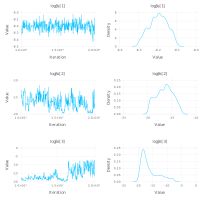

Press ENTER to draw next plot


stdin>  


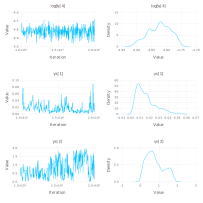

Press ENTER to draw next plot


stdin>  


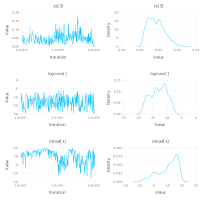

Mamba.draw(Mamba.plot(chain0[:, showparam, :])) = nothing
Iterations = 10004:20000
Thinning interval = 4
Chains = 1
Samples per chain = 2500

Empirical Posterior Estimates:
                    Mean                   SD                   Naive SE                  MCSE              ESS   
  logβs[1]   2.755136665433×10⁻⁴   1.5078919372489×10⁻⁵  3.015783874497851×10⁻⁷  9.483691165368624×10⁻⁷ 252.804984
  logβs[2] 3.00845202310076×10⁻⁷ 6.712895393596401×10⁻⁷ 1.3425790787192811×10⁻⁸ 6.0382300168353789×10⁻⁸ 123.594872
  logβs[3]  2.3025444682326×10⁻⁵   9.2628293055813×10⁻⁵   1.85256586111626×10⁻⁶   9.85467273773764×10⁻⁶  88.349259
  logβs[4]    8.05014590791×10⁻³    3.466456468898×10⁻⁴   6.93291293779594×10⁻⁶    1.7676552028374×10⁻⁵ 384.570875
 logrcom[]  5.1567222441126×10⁻⁵    1.853938449893×10⁻⁴   3.70787689978592×10⁻⁶   9.82075913979483×10⁻⁶ 356.369480
infcoef[1]        1.65266054×10⁷         4.02842252×10⁷          8.05684504×10⁵          6.09288026×10⁶  43.714422

Quantiles:
          

In [342]:
Base.exp(chain::ModelChains)=begin newchain=deepcopy(chain);newchain.value.=exp.(chain.value);newchain end
showparam=[:logβs,:γs,:logrcom,:infcoef]
@show Mamba.draw(Mamba.plot(chain1[:,showparam,:]))
describe(exp(chain0[:,[:logβs,:logrcom,:infcoef],:]))
describe(chain1[:,[:γs,:llvalue],:])

In [219]:
write("Matsumoto_chain1.jls", chain1)